<a href="https://colab.research.google.com/github/Cpt-Shaan/ocr-captcha/blob/main/ocr_to_tts_captcha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [1]:
import os
import zipfile
import random
from pathlib import Path
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

## Downloading dataset

In [2]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8863k  100 8863k    0     0  5946k      0  0:00:01  0:00:01 --:--:-- 26.2M


In [3]:
data_dir = Path("./captcha_images_v2/")


# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = sorted(set(char for label in labels for char in label))


print(f"Number of images found: {len(images)}")
print(f"Number of labels found: {len(labels)}")
print(f"Number of unique characters: {len(characters)}")
print(f"Characters present: {characters}")


# Mapping from char to index and back
char_to_idx = {ch: idx for idx, ch in enumerate(characters)}
idx_to_char = {idx: ch for ch, idx in char_to_idx.items()}

Number of images found: 1040
Number of labels found: 1040
Number of unique characters: 19
Characters present: ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


## Dataloader for dataset

In [5]:
class CaptchaDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("L")

        if self.transform:
            img = self.transform(img)

        target = torch.tensor([char_to_idx[c] for c in label], dtype=torch.long)
        return img, target, label

## Preprocessing and Splits

In [6]:
transform = transforms.Compose([
    transforms.Resize((50, 200)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_dataset = CaptchaDataset(images, labels, transform=transform)

# Train/Val split
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

def collate_fn(batch):
    imgs, targets, labels = zip(*batch)
    imgs = torch.stack(imgs)
    target_lengths = [len(t) for t in targets]
    targets = torch.cat(targets)
    return imgs, targets, target_lengths, labels

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

## CRNN model

In [17]:
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 1), (2, 1)),

            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d((2, 1), (2, 1)),

            nn.Conv2d(512, 512, 2, stride=1, padding=0),
            nn.ReLU()
        )
        self.lstm = nn.LSTM(512 * 2, 256, num_layers=2, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        b, c, h, w = x.size()
        # Reshape to (batch_size, sequence_length, input_size)
        # where sequence_length is the width and input_size is c * h
        x = x.view(b, w, c * h)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

## Setting device and hyper-params

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CRNN(len(characters) + 1).to(device) # +1 for CTC blank
criterion = nn.CTCLoss(blank=len(characters))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

## Train and Validation loops

In [19]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    epoch_loss = 0
    for imgs, targets, target_lengths, _ in loader:
        imgs = imgs.to(device)
        targets = targets.to(device)


        optimizer.zero_grad()
        outputs = model(imgs)
        outputs = outputs.log_softmax(2)
        input_lengths = torch.full(size=(outputs.size(0),), fill_value=outputs.size(1), dtype=torch.long)
        loss = criterion(outputs.permute(1, 0, 2), targets, input_lengths, torch.tensor(target_lengths))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(loader)

def validate(model, loader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, targets, target_lengths, _ in loader:
            imgs = imgs.to(device)
            targets = targets.to(device)
            outputs = model(imgs)
            outputs = outputs.log_softmax(2)
            input_lengths = torch.full(size=(outputs.size(0),), fill_value=outputs.size(1), dtype=torch.long)
            loss = criterion(outputs.permute(1, 0, 2), targets, input_lengths, torch.tensor(target_lengths))
            val_loss += loss.item()
    return val_loss / len(loader)

## Inferencing output from model

In [20]:
def greedy_decoder(output):
    argmaxes = torch.argmax(output, dim=2)
    decodes = []
    for i in range(argmaxes.size(0)):
        decode = []
        prev = -1
        for j in range(argmaxes.size(1)):
            if argmaxes[i, j].item() != prev and argmaxes[i, j].item() != len(characters):
                decode.append(idx_to_char[argmaxes[i, j].item()])
            prev = argmaxes[i, j].item()
        decodes.append("".join(decode))
    return decodes

## Training Process

In [45]:
for epoch in range(100):
    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_loss = validate(model, val_loader)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1, Train Loss: 8.6151, Val Loss: 3.3286
Epoch 2, Train Loss: 3.3050, Val Loss: 3.2609
Epoch 3, Train Loss: 3.2631, Val Loss: 3.2602
Epoch 4, Train Loss: 3.2609, Val Loss: 3.2606
Epoch 5, Train Loss: 3.2611, Val Loss: 3.2599
Epoch 6, Train Loss: 3.2591, Val Loss: 3.2605
Epoch 7, Train Loss: 3.2622, Val Loss: 3.2604
Epoch 8, Train Loss: 3.2608, Val Loss: 3.2611
Epoch 9, Train Loss: 3.2579, Val Loss: 3.2595
Epoch 10, Train Loss: 3.2579, Val Loss: 3.2621
Epoch 11, Train Loss: 3.2587, Val Loss: 3.2569
Epoch 12, Train Loss: 3.2569, Val Loss: 3.2580
Epoch 13, Train Loss: 3.2538, Val Loss: 3.2539
Epoch 14, Train Loss: 3.2523, Val Loss: 3.2554
Epoch 15, Train Loss: 3.2479, Val Loss: 3.2494
Epoch 16, Train Loss: 3.2399, Val Loss: 3.2393
Epoch 17, Train Loss: 3.2219, Val Loss: 3.2219
Epoch 18, Train Loss: 3.1878, Val Loss: 3.1993
Epoch 19, Train Loss: 3.1202, Val Loss: 3.1380
Epoch 20, Train Loss: 2.9964, Val Loss: 3.1167
Epoch 21, Train Loss: 2.8604, Val Loss: 2.8296
Epoch 22, Train Loss: 

In [46]:
def image_to_text(model, img_path):
    img = Image.open(img_path).convert('L')
    transform = transforms.Compose([
        transforms.Resize((50, 200)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img).log_softmax(2)
        pred = greedy_decoder(output.cpu())
    return pred

In [47]:
pred = image_to_text(model, images[133])

In [48]:
pred

['4egem']

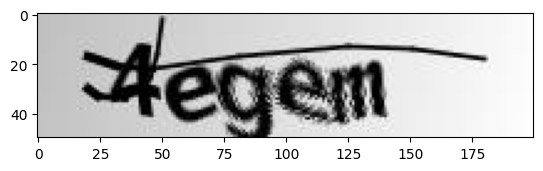

In [49]:
%matplotlib inline

import matplotlib.pyplot as plt

img = Image.open(images[133])
plt.imshow(img)

## Setting up kokoro for TTS on CRNN output

In [62]:
!pip install -q kokoro>=0.9.2 soundfile
!apt-get -qq -y install espeak-ng > /dev/null 2>&1
from kokoro import KPipeline
from IPython.display import display, Audio
import soundfile as sf
import torch
pipeline = KPipeline(lang_code='a')

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


## Final pipeline for image to speech generation

In [65]:
import soundfile as sf
from IPython.display import Audio, display

class OCR_TTS:
    def __init__(self, model, idx_to_char, characters, pipeline):
        self.model = model
        self.idx_to_char = idx_to_char
        self.characters = characters


    def image_to_text(self, img_path):
        img = Image.open(img_path).convert("L")
        transform = transforms.Compose([
            transforms.Resize((50, 200)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        img = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            output = self.model(img).log_softmax(2)
        pred = greedy_decoder(output.cpu())[0]
        return pred

    def text_to_speech(self, text, out_path = "test_output.wav"):
        try:
            generator = pipeline(text, voice='af_heart')
            for i, (gs, ps, audio) in enumerate(generator):
                # print(i, gs, ps)
                display(Audio(data=audio, rate=24000, autoplay=i==0))
                sf.write(f'{i}.wav', audio, 24000)
        except ImportError:
            print("Kokoro TTS not installed. Returning text only.")

    def image_to_speech(self, img_path):
        img = Image.open(img_path)
        plt.imshow(img)
        text = self.image_to_text(img_path)
        self.text_to_speech(text)
        return text

22d5n


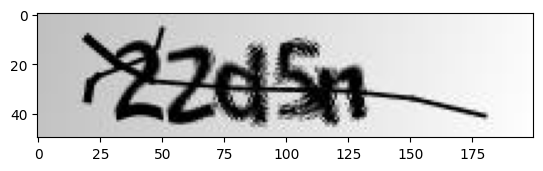

In [67]:
ocr_tts = OCR_TTS(model, idx_to_char, characters, pipeline)

text = ocr_tts.image_to_speech(images[1])
print(text)

## Saving and Loading models

In [74]:
torch.save(model.state_dict(), "ocr_captv1.pth")

In [75]:
newOCR = CRNN(len(characters) + 1)
newOCR.load_state_dict(torch.load("ocr.pth"))

<All keys matched successfully>